# Packages Loading


In [22]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg
import yaml
from tqdm import tqdm

from analysis.dataset.june_dataset import JuNEDataset
from analysis.metrics.metrics_graph import GraphMetrics
from analysis.metrics.utils.graph_tools import dataframe_to_graphviz


def read_config(config_path: Path = Path("data_config.yaml")) -> dict:
    with config_path.open("r") as stream:
        try:
            return yaml.safe_load(stream)
        except yaml.YAMLError:
            return {}


config = read_config()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read Data


In [2]:
df_hack = pd.read_csv(config.get("dataset_path"), index_col=0)
df_labels = pd.read_csv(config.get("label_mapping_path"), index_col=0)
df_hack = df_hack.merge(df_labels, on='action_id')

df_hack.head()


,action_id,time,session_id,kernel_id,notebook_name,event,cell_index,cell_num,cell_type,cell_source,cell_output,user_id,expert,cell_label
0,0,2023-05-06 10:32:26.282,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,save_notebook,NaN,NaN,NaN,"[\n {\n ""id"": ""35c0b3b694f84140846a21197ea...",NaN,student_7,False,NaN
1,1,2023-05-06 10:32:55.892,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,NaN,student_7,False,helper_functions
2,2,2023-05-06 10:32:56.229,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,finished_execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,"[{""output_type"":""stream"",""size"":23}]",student_7,False,helper_functions
3,3,2023-05-06 10:32:58.048,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,NaN,student_7,False,helper_functions
4,4,2023-05-06 10:32:58.429,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,finished_execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,"[{""output_type"":""stream"",""size"":23}]",student_7,False,helper_functions


In [3]:
june = JuNEDataset(df_hack)
june.prepare_dataset()
june.df.head()


,action_id,time,session_id,kernel_id,notebook_name,event,cell_index,cell_num,cell_type,cell_source,cell_output,user_id,expert,cell_label,task
0,0,2023-05-06 10:32:26.282,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,save_notebook,None,None,None,"[\n {\n ""id"": ""35c0b3b694f84140846a21197ea...",None,student_7,False,None,task1
1,1,2023-05-06 10:32:55.892,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,None,student_7,False,helper_functions,task1
2,2,2023-05-06 10:32:56.229,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,finished_execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,"[{""output_type"":""stream"",""size"":23}]",student_7,False,helper_functions,task1
3,3,2023-05-06 10:32:58.048,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,None,student_7,False,helper_functions,task1
4,4,2023-05-06 10:32:58.429,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,finished_execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,"[{""output_type"":""stream"",""size"":23}]",student_7,False,helper_functions,task1


# Initialize Metrics Processor


In [4]:
processor = GraphMetrics()


# Metrics Calculation


In [5]:
grouped = june.df.groupby("kernel_id")
df_kernel = grouped.get_group(list(grouped.groups.keys())[0])
df_kernel.head()


,action_id,time,session_id,kernel_id,notebook_name,event,cell_index,cell_num,cell_type,cell_source,cell_output,user_id,expert,cell_label,task
1113,1113,2023-05-06 11:58:35.270,7215278a-b19d-477e-82df-9a03bb979fb6,0033f76c-6179-4fb4-a9ce-79112a52b51c,task1.ipynb,execute,e139884774504ae997d7e38e6be6da88,0.0,code,# # Do not forget to check if your notebook lo...,None,student_0,False,helper_functions,task1
1114,1114,2023-05-06 11:58:58.001,7215278a-b19d-477e-82df-9a03bb979fb6,0033f76c-6179-4fb4-a9ce-79112a52b51c,task1.ipynb,finished_execute,e139884774504ae997d7e38e6be6da88,0.0,code,# # Do not forget to check if your notebook lo...,"[{""output_type"":""stream"",""size"":23}]",student_0,False,helper_functions,task1
1115,1115,2023-05-06 11:58:58.174,7215278a-b19d-477e-82df-9a03bb979fb6,0033f76c-6179-4fb4-a9ce-79112a52b51c,task1.ipynb,save_notebook,None,None,None,"[\n {\n ""id"": ""e139884774504ae997d7e38e6be...",None,student_0,False,None,task1
1116,1116,2023-05-06 11:59:02.653,7215278a-b19d-477e-82df-9a03bb979fb6,0033f76c-6179-4fb4-a9ce-79112a52b51c,task1.ipynb,execute,a47800e62cbe40c1ad4003b2879f5f03,1.0,code,!pip install pandas\n,None,student_0,False,helper_functions,task1
1117,1117,2023-05-06 11:59:03.475,7215278a-b19d-477e-82df-9a03bb979fb6,0033f76c-6179-4fb4-a9ce-79112a52b51c,task1.ipynb,finished_execute,a47800e62cbe40c1ad4003b2879f5f03,2.0,code,!pip install pandas\n,"[{""output_type"":""stream"",""size"":649}]",student_0,False,load_data,task1


In [6]:
graph_metrics = processor.calculate_kernel_metrics(df_kernel)
graph_metrics.head()


,kernel_id,modularity,average_degree,average_clustering
0,0033f76c-6179-4fb4-a9ce-79112a52b51c,0.283695,18.9,0.270952


In [7]:
graph_metrics = processor.calculate_metrics(june.df)
graph_metrics.head()


100%|██████████| 31/31 [00:19<00:00,  1.57it/s]


,kernel_id,modularity,average_degree,average_clustering
0,0033f76c-6179-4fb4-a9ce-79112a52b51c,0.283695,18.900000,0.270952
0,033a2c63-4cfb-4cc5-9988-59c48a06eb23,0.580378,5.071429,0.127423
0,19160d7e-eb8e-4a81-9e92-e9d8335eee31,0.564548,10.238095,0.252116
0,232bcb48-7455-4109-9eeb-809649a6bedc,0.502743,12.985507,0.229112
0,29da7c56-5a69-485f-b181-a0a7199a559c,0.572181,7.943396,0.143793


In [8]:
df_tmp = june.df[['user_id', 'kernel_id', 'expert', 'task']] \
    .drop_duplicates(subset=['user_id', 'kernel_id', 'expert'], keep='last')

graph_metrics_merged = graph_metrics.merge(df_tmp, on='kernel_id')
graph_metrics_merged.head()


,kernel_id,modularity,average_degree,average_clustering,user_id,expert,task
0,0033f76c-6179-4fb4-a9ce-79112a52b51c,0.283695,18.900000,0.270952,student_0,False,task1
1,033a2c63-4cfb-4cc5-9988-59c48a06eb23,0.580378,5.071429,0.127423,student_0,False,task1
2,19160d7e-eb8e-4a81-9e92-e9d8335eee31,0.564548,10.238095,0.252116,expert_5,True,task1
3,232bcb48-7455-4109-9eeb-809649a6bedc,0.502743,12.985507,0.229112,expert_1,True,task2
4,29da7c56-5a69-485f-b181-a0a7199a559c,0.572181,7.943396,0.143793,student_2,False,task1


In [11]:
metrics = list(processor.graph_metrics_mapping.keys())
graph_table = graph_metrics_merged.groupby(['task', 'expert'])[metrics].mean().round(2).applymap('{:.2f}'.format)
graph_table


modularity average_degree average_clustering
task  expert                                             
task1 False        0.52          11.58               0.20
      True         0.53          12.23               0.20
task2 False        0.47          11.08               0.23
      True         0.55           8.72               0.23

In [12]:
print(graph_table.to_latex(escape=True, multirow=True))


\begin{tabular}{lllll}
\toprule
 &  & modularity & average\_degree & average\_clustering \\
task & expert &  &  &  \\
\midrule
\multirow[t]{2}{*}{task1} & False & 0.52 & 11.58 & 0.20 \\
 & True & 0.53 & 12.23 & 0.20 \\
\cline{1-5}
\multirow[t]{2}{*}{task2} & False & 0.47 & 11.08 & 0.23 \\
 & True & 0.55 & 8.72 & 0.23 \\
\cline{1-5}
\bottomrule
\end{tabular}


In [14]:
graph_metrics_merged.anova(dv="modularity", between=["expert", "task"]).round(3)


,Source,SS,DF,MS,F,p-unc,np2
0,expert,0.013,1.0,0.013,1.783,0.193,0.062
1,task,0.004,1.0,0.004,0.560,0.461,0.020
2,expert * task,0.007,1.0,0.007,1.061,0.312,0.038
3,Residual,0.190,27.0,0.007,NaN,NaN,NaN


In [15]:
graph_metrics_merged.anova(dv="average_degree", between=["expert", "task"]).round(3)


,Source,SS,DF,MS,F,p-unc,np2
0,expert,3.293,1.0,3.293,0.055,0.816,0.002
1,task,19.671,1.0,19.671,0.328,0.571,0.012
2,expert * task,15.003,1.0,15.003,0.251,0.621,0.009
3,Residual,1616.855,27.0,59.884,NaN,NaN,NaN


In [16]:
graph_metrics_merged.anova(dv="average_clustering", between=["expert", "task"]).round(3)


,Source,SS,DF,MS,F,p-unc,np2
0,expert,0.000,1.0,0.000,0.024,0.877,0.001
1,task,0.007,1.0,0.007,1.161,0.291,0.041
2,expert * task,0.000,1.0,0.000,0.013,0.910,0.000
3,Residual,0.167,27.0,0.006,NaN,NaN,NaN



# Display graph

In [19]:
graphs = {}
grouped = june.df.groupby(['user_id', 'kernel_id'])

for (user_id, kernel_id), g in tqdm(grouped):
    df_kernel = g
    gv = dataframe_to_graphviz(df_kernel)
    gv.attr(rankdir='LR', size='100,100')
    gv.render(directory='figures/graphs', format='png', filename=f"graph_{user_id}", cleanup=True).replace('\\', '/')
    graphs[(user_id, kernel_id)] = gv


100%|██████████| 31/31 [00:29<00:00,  1.04it/s]


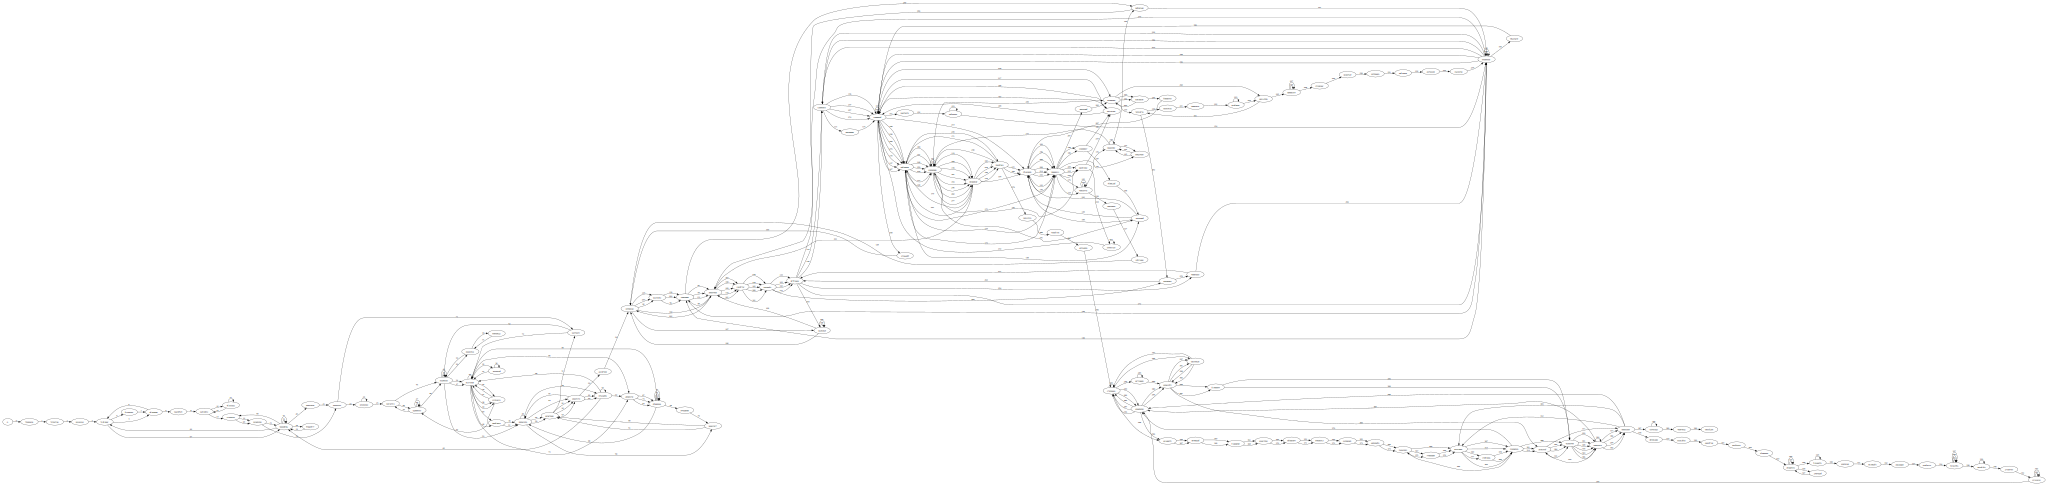

In [20]:
list(graphs.values())[0]


In [24]:
grouped = june.df.groupby("kernel_id")

load = True
if not load:
    evolution_dfs = [
        pd.concat(
            [processor.calculate_metrics(g.iloc[:i], progress=False)
             for i in tqdm(range(1, g.shape[0], 10))], axis=0, ignore_index=True
        ).reset_index().rename({"index": "state_num"}, axis=1)
        for kernel_id, g in grouped
    ]

    all_evolutions = pd.concat(evolution_dfs, axis=0, ignore_index=True)
    all_evolutions.to_csv("../data/graph_evolution_distill.csv")
else:
    all_evolutions = pd.read_csv(config.get("graph_evolution_path"), index_col=0)

all_evolutions.head()


,state_num,kernel_id,modularity,average_degree,average_clustering
0,0,0033f76c-6179-4fb4-a9ce-79112a52b51c,0.000000,1.000000,0.0
1,1,0033f76c-6179-4fb4-a9ce-79112a52b51c,0.300000,1.666667,0.0
2,2,0033f76c-6179-4fb4-a9ce-79112a52b51c,0.401235,2.000000,0.0
3,3,0033f76c-6179-4fb4-a9ce-79112a52b51c,0.488166,2.000000,0.0
4,4,0033f76c-6179-4fb4-a9ce-79112a52b51c,0.495556,2.428571,0.0


In [25]:
def continuous_transform(x, y, size: int = 1000, normalize: bool = True) -> tuple[np.ndarray, np.ndarray]:
    x_max = 1 if normalize else np.max(x)
    xp = np.linspace(0, x_max, size)
    x = np.linspace(0, x_max, len(y))
    y = np.array(y)

    y[np.isnan(y)] = 0
    y = np.interp(xp, x, y) + 1e-5
    return xp, y


In [26]:
import seaborn as sns

sns.reset_orig()


In [27]:
plt.style.use('https://github.com/klieret/simple-science-style/raw/main/stylesheets/sss1.mplstyle')
plt.rcParams["font.family"] = "Times New Roman"


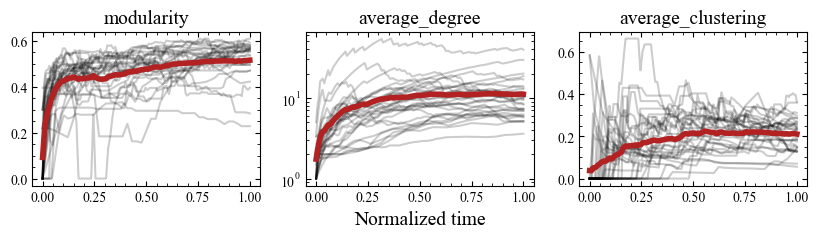

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(10, 2))

for i, metric in enumerate(metrics):
    ax = axs[i]
    curves = []
    for kernel_id, g in all_evolutions.groupby("kernel_id"):
        x, y = continuous_transform(
            np.linspace(0, 1, g[metric].shape[0]),
            g[metric]
        )
        curves.append(y)
        ax.plot(x, y, alpha=0.2, color='k')

    ax.set_title(metric, fontsize=14)
    ax.plot(x, np.sum(curves, axis=0) / len(curves), color='firebrick', lw=4)

axs[1].set_xlabel("Normalized time", fontsize=14)
axs[1].set_yscale("log")
plt.savefig("figures/evolution/graph_metrics.pdf", dpi=300, bbox_inches='tight')
plt.show()


In [30]:
df_tmp = june.df[['user_id', 'kernel_id', 'expert', 'task']] \
    .drop_duplicates(subset=['user_id', 'kernel_id', 'expert'], keep='last')

graph_evolution_merged = all_evolutions.merge(df_tmp, on='kernel_id')
graph_evolution_merged.head()


,state_num,kernel_id,modularity,average_degree,average_clustering,user_id,expert,task
0,0,0033f76c-6179-4fb4-a9ce-79112a52b51c,0.000000,1.000000,0.0,student_0,False,task1
1,1,0033f76c-6179-4fb4-a9ce-79112a52b51c,0.300000,1.666667,0.0,student_0,False,task1
2,2,0033f76c-6179-4fb4-a9ce-79112a52b51c,0.401235,2.000000,0.0,student_0,False,task1
3,3,0033f76c-6179-4fb4-a9ce-79112a52b51c,0.488166,2.000000,0.0,student_0,False,task1
4,4,0033f76c-6179-4fb4-a9ce-79112a52b51c,0.495556,2.428571,0.0,student_0,False,task1


In [31]:
df_tmp = graph_evolution_merged
max_values = df_tmp.groupby('kernel_id')['state_num'].transform('max')
df_tmp['normalized_state'] = df_tmp['state_num'] / max_values

df_corr = df_tmp.groupby(['task', 'expert'])[['normalized_state', *metrics]].corr()
indices = [i for i in df_corr.index if i[-1] == 'normalized_state']
df_corr[metrics] = df_corr[metrics]

table = df_corr.loc[indices][metrics].droplevel(2)
table.round(3)


modularity  average_degree  average_clustering
task  expert                                                
task1 False        0.433           0.152               0.329
      True         0.612           0.465               0.392
task2 False        0.359           0.415               0.423
      True         0.640           0.650               0.478

In [32]:
print(table.round(2).applymap('{:.2f}'.format).to_latex(escape=True, multirow=True))


\begin{tabular}{lllll}
\toprule
 &  & modularity & average\_degree & average\_clustering \\
task & expert &  &  &  \\
\midrule
\multirow[t]{2}{*}{task1} & False & 0.43 & 0.15 & 0.33 \\
 & True & 0.61 & 0.46 & 0.39 \\
\cline{1-5}
\multirow[t]{2}{*}{task2} & False & 0.36 & 0.42 & 0.42 \\
 & True & 0.64 & 0.65 & 0.48 \\
\cline{1-5}
\bottomrule
\end{tabular}


In [33]:
alpha = 0.05
for task in ['task1', 'task2']:
    for expert in [True, False]:
        for metric in metrics:
            df_sample = df_tmp[(df_tmp.task == task) & (df_tmp.expert == expert)][['normalized_state', metric]]
            cor = pg.corr(df_sample.normalized_state, df_sample[metric])
            if cor['p-val'].iloc[0] > alpha:
                print(metric, task, expert, cor['r'].iloc[0].round(2), cor['p-val'].iloc[0].round(2))
